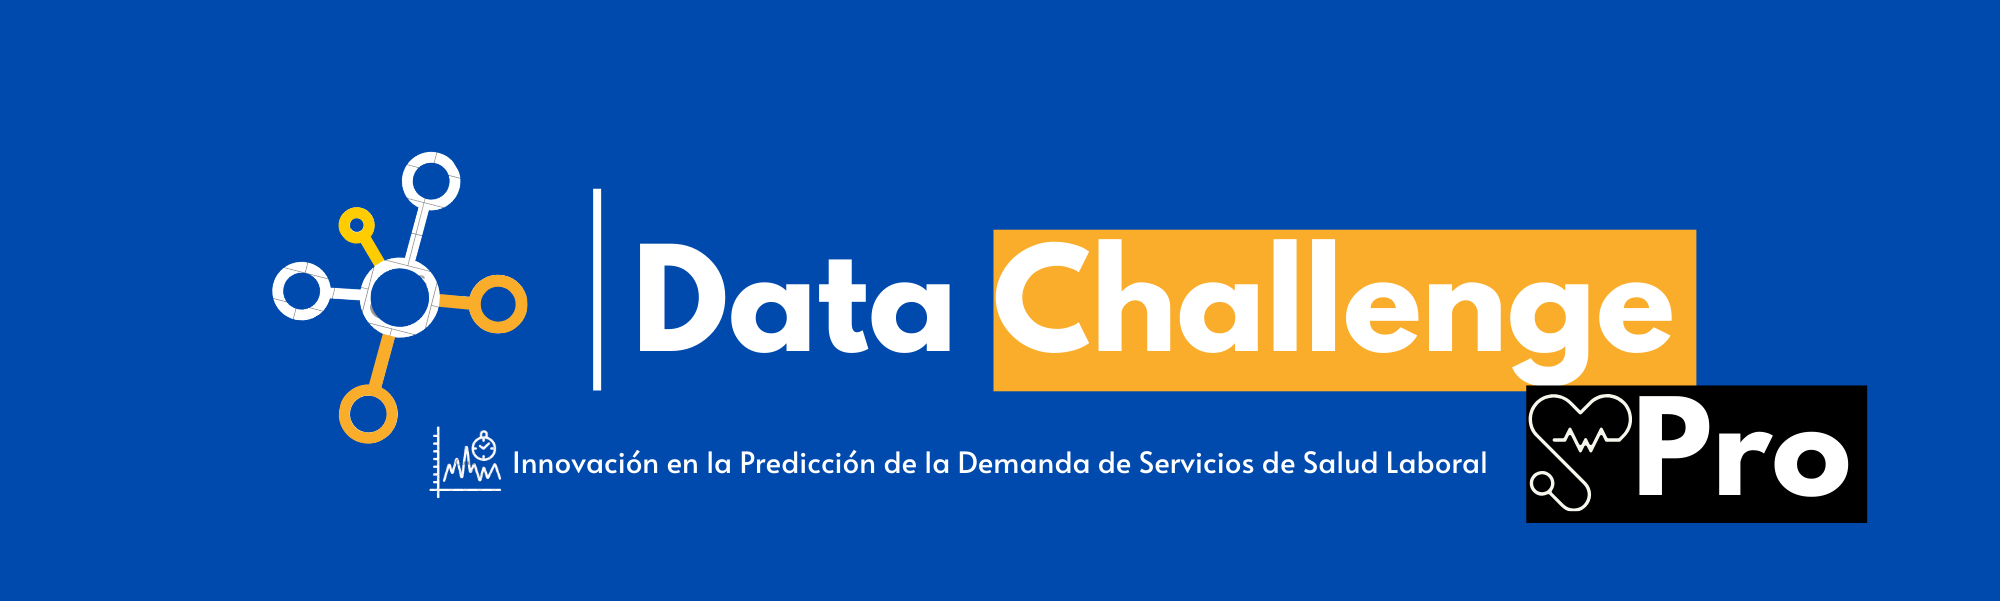


#***CREDITOS*** :
##ALEXANDER RANGEL VIZCAINO
##ANA CRISTINA MEZA GARCIA
##DANIER CONDE RAMOS

In [201]:
!pip install prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
import itertools
import holidays
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

#***LECTURA DE DATOS***

In [202]:
dataset = pd.read_csv('--------------------------REEMPLAZAR RUTA LUEGO DE DESCOMPRIMIR CSV--------------------')
dataset["ds"]= pd.to_datetime(dataset["ds"])
#Datos hasta el 30 de abril de 2024
dataset_entrenamiento = dataset[dataset['ds'] < '2024-04-30']
dataset_entrenamiento['ds'] = pd.to_datetime(dataset_entrenamiento['ds'])
#Datos a partir del 01 de Mayo de 2024
dataset_prueba = dataset[dataset['ds'] >= '2024-04-30']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#***ELECCION DEL MUNICIPIO Y SERVICIO***

In [203]:

# 📌 Extraer lista única de municipios y servicios
municipios = []
servicios = []

for i in dataset["unique_id"].unique():
    if i.split(" - ")[0] not in municipios:
        municipios.append(i.split(" - ")[0])
    if i.split(" - ")[1] not in servicios:
        servicios.append(i.split(" - ")[1])

# 🎛️ Dropdowns
dropdown_municipio = widgets.Dropdown(
    options=sorted(municipios),
    description='Selecciona un municipio:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

dropdown_servicio = widgets.Dropdown(
    options=sorted(servicios),
    description='Selecciona un servicio:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# 🔘 Botón de ejecución final
boton_filtrar = widgets.Button(
    description='Filtrar datos',
    button_style='primary',
    tooltip='Filtrar y mostrar',
    icon='search'
)

# Área de salida
salida = widgets.Output()

# 📌 Lógica al presionar el botón
def filtrar_datos(b):
    salida.clear_output()
    municipio = dropdown_municipio.value
    servicio = dropdown_servicio.value
    serie_consultada = f"{municipio} - {servicio}"

    # Filtrar el dataset original
    datos_filtrados = dataset[dataset["unique_id"] == serie_consultada].copy()

    with salida:
        if datos_filtrados.empty:
            print("⚠️ No se encontraron datos para la combinación seleccionada.")
        else:
            print(f"✅ Mostrando datos de: {serie_consultada}")
            display(datos_filtrados.head())

# Asociar evento al botón
boton_filtrar.on_click(filtrar_datos)

# Mostrar todo
display(dropdown_municipio, dropdown_servicio, boton_filtrar, salida)


Dropdown(description='Selecciona un municipio:', layout=Layout(width='50%'), options=('ABEJORRAL', 'ABREGO', '…

Dropdown(description='Selecciona un servicio:', layout=Layout(width='50%'), options=('ACUPUNTURA (L)', 'ANAL C…

Button(button_style='primary', description='Filtrar datos', icon='search', style=ButtonStyle(), tooltip='Filtr…

Output()

,ds,unique_id,y,weekday,month,year
1304320,2021-07-01,BARRANQUILLA - SESIONES DE FISIOTERAPIA,156.0,3,7,2021
1304321,2021-07-02,BARRANQUILLA - SESIONES DE FISIOTERAPIA,65.0,4,7,2021
1304322,2021-07-03,BARRANQUILLA - SESIONES DE FISIOTERAPIA,14.0,5,7,2021
1304323,2021-07-04,BARRANQUILLA - SESIONES DE FISIOTERAPIA,0.0,6,7,2021
1304324,2021-07-05,BARRANQUILLA - SESIONES DE FISIOTERAPIA,0.0,0,7,2021


#***ENTRENAMIENTO DEL MODELO Y HYPER PARAMETER TUNING***

In [204]:
dataset["ds"]= pd.to_datetime(dataset["ds"])
#Datos hasta el 30 de abril de 2024
dataset_entrenamiento = dataset[dataset['ds'] < '2024-04-30']
dataset_entrenamiento['ds'] = pd.to_datetime(dataset_entrenamiento['ds'])
#Datos a partir del 01 de Mayo de 2024
dataset_prueba = dataset[dataset['ds'] >= '2024-04-30']

# 🔍 Seleccionamos la serie específica combinando municipio y servicio
serie_consultada = municipio_seleccionado + " - " + servicio_seleccionado

# Filtramos el conjunto de prueba para quedarnos solo con la serie consultada
dataset_prueba = dataset_prueba[dataset_prueba['unique_id'] == serie_consultada]

# Filtramos también el conjunto de entrenamiento
dataset_entrenamiento = dataset_entrenamiento[dataset_entrenamiento['unique_id'] == serie_consultada]

# Unimos los datasets de entrenamiento y prueba para luego ajustar el modelo final
dataset_union = pd.concat([dataset_entrenamiento, dataset_prueba])

# 📅 Generamos un DataFrame con los festivos en Colombia desde 2021 hasta 2025
holidays = pd.DataFrame(
    holidays.CO(years=[2025, 2024, 2023, 2022, 2021]).items(),
    columns=['ds', 'holiday']
)

# 🎯 Definimos una cuadrícula de hiperparámetros para hacer búsqueda por fuerza bruta
param_grid = {
    'seasonality_mode': ["multiplicative", "additive"],  # Tipo de estacionalidad
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],  # Controla sensibilidad al cambio
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],         # Controla la flexibilidad de la estacionalidad
}

# 🔄 Generamos todas las combinaciones posibles de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Mostramos cuántas combinaciones vamos a evaluar
print(len(all_params))

# Guardamos la longitud de los datasets
n_entrenamiento = len(dataset_entrenamiento)
n_prueba = len(dataset_prueba)

# Inicializamos lista para guardar los errores MAE de cada combinación
maes = []

# 🔁 Iteramos sobre todas las combinaciones de hiperparámetros
for params in all_params:
    # Creamos un modelo Prophet con los parámetros actuales y los festivos
    model = Prophet(holidays=holidays, holidays_prior_scale=20, **params)

    # Agregamos los festivos nacionales de Colombia
    model.add_country_holidays(country_name='CO')

    # Añadimos estacionalidad semanal de forma manual
    model.add_seasonality(name='weekly', period=7, fourier_order=5)

    # Entrenamos el modelo con el conjunto de entrenamiento
    model.fit(dataset_entrenamiento)

    # Realizamos predicción sobre el conjunto de prueba
    forecast = model.predict(dataset_prueba)

    # Calculamos el MAE comparando valores reales vs predichos
    mae = mean_absolute_error(dataset_prueba['y'].values, forecast['yhat'].values)

    # Guardamos el MAE de esta combinación
    maes.append(mae)

# 📊 Creamos un DataFrame con los resultados del tuning
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

# ⚡ Identificamos la mejor combinación (la que tiene menor MAE)
best_params = all_params[np.argmin(maes)]

# 🎯 Entrenamos el modelo final con los mejores hiperparámetros y todos los datos disponibles
model = Prophet(holidays=holidays, holidays_prior_scale=20, **best_params)
model.add_country_holidays(country_name='CO')
model.add_seasonality(name='weekly', period=7, fourier_order=5)

model.fit(dataset_union)

# 📈 Generamos la predicción final con el modelo ya ajustado
prediccion = model.predict(dataset_prueba)


INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40


DEBUG:cmdstanpy:input tempfile: /tmp/tmphpwh171g/1r40tphw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphpwh171g/2l6kglxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96540', 'data', 'file=/tmp/tmphpwh171g/1r40tphw.json', 'init=/tmp/tmphpwh171g/2l6kglxl.json', 'output', 'file=/tmp/tmphpwh171g/prophet_model8urxdy6l/prophet_model-20250425055800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:58:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:58:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphpwh171


 -------------------------------------------------------------------------------- 
📉 COMPONENTES DEL MODELO
 -------------------------------------------------------------------------------- 



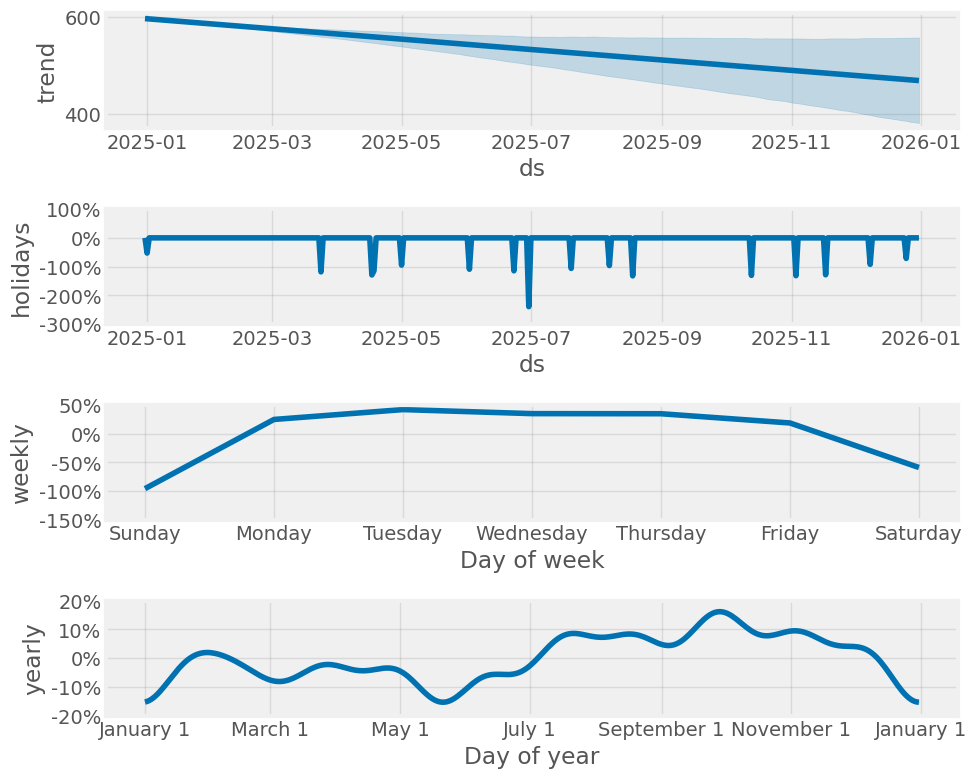

📁 Archivo CSV disponible


In [205]:

# 📆 Generar fechas futuras (1 año)
dias_futuros = 365
future_df = model.make_future_dataframe(periods=dias_futuros)
future_df = future_df.tail(dias_futuros + 1)

# 🔮 Predecir
forecast = model.predict(future_df)

# 🧼 Postprocesar
forecast['yhat'] = forecast['yhat'].round()
forecast['yhat'] = forecast['yhat'].clip(lower=0)

forecast['yhat_lower'] = forecast['yhat_lower'].round()
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

forecast['yhat_upper'] = forecast['yhat_upper'].round()
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)


# 🗂️ Exportar predicción como CSV
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("forecast_prophet.csv", index=False)


# 📈 Crear gráfico interactivo con bandas de confianza
fig = px.line(forecast, x='ds', y='yhat', title='📈 Pronóstico con Prophet',
              labels={'ds': 'Fecha', 'yhat': 'Valor Predicho'})

fig.add_scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='Límite Inferior', line=dict(dash='dot'))
fig.add_scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='Límite Superior', line=dict(dash='dot'))


# 🎨 Mejorar diseño
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor Predicho',
    template='plotly_white',
    hovermode='x unified',
    margin=dict(t=50, l=40, r=40, b=40)
)

fig.show()

# 🔻 Separador visual para los componentes
print("\n", "-" * 80, "\n📉 COMPONENTES DEL MODELO\n", "-" * 80, "\n")

# 🧩 Mostrar componentes del modelo
fig_componentes = model.plot_components(forecast)
fig_componentes.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


# 📎 Archivo CSV exportado
print("📁 Archivo CSV disponible")